In [37]:
parPercents=[83.8202, 84.1504, 84.4806, 84.8108, 85.1410, 85.4712, 85.8014, 86.1316, 86.4816, 86.7920, 87.1222, 87.4524, 87.7826, 88.1128, 88.4430]
superfluousPercents=list(range(2, 31, 2))
egPercents=[100-par for par in parPercents]
egPercents

[16.1798,
 15.849599999999995,
 15.519400000000005,
 15.1892,
 14.858999999999995,
 14.528800000000004,
 14.198599999999999,
 13.868399999999994,
 13.5184,
 13.207999999999998,
 12.877799999999993,
 12.547600000000003,
 12.217399999999998,
 11.887200000000007,
 11.557000000000002]

In [38]:
(5.5/807.51)/((5.5/807.51)+(31)/914)

0.16723325929205807

In [39]:
nonsuperfluousPar=[par-sup for par, sup in zip(parPercents, superfluousPercents)]
nonsuperfluousEGPer=[egPer/(egPer+nonSupPar) for egPer, nonSupPar in zip(egPercents, nonsuperfluousPar)]

In [40]:
nonsuperfluousEGPer

[0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16485853658536584,
 0.16509999999999997,
 0.1650999999999999,
 0.16510000000000002,
 0.16509999999999997,
 0.1651000000000001,
 0.16510000000000002]

(15, 15)

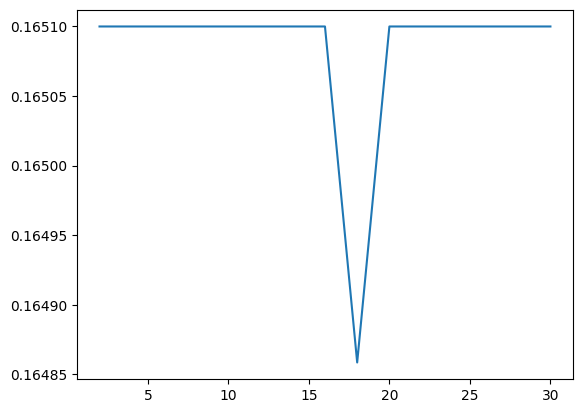

In [41]:
import matplotlib.pyplot as plt
plt.plot(superfluousPercents, nonsuperfluousEGPer)
len(superfluousPercents), len(nonsuperfluousEGPer)

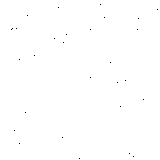

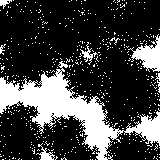

In [67]:
absorptionRate=.1651
import random
import torch
import torchvision as tv
from collections import deque

grid=torch.rand((160, 160))
grid

tensorToImageTransform=tv.transforms.ToPILImage()

def corePhase(grid, prob=0.05):
    return (grid>prob).float()

grid=corePhase(grid, 0.001)
display(tensorToImageTransform(grid))

tensorToImageTransform(grid)
def growthPhase(grid, prob, endingWt):
    idxs=torch.nonzero(grid==0)
    if (grid.shape[0]*grid.shape[1]-len(idxs))/(grid.shape[0]*grid.shape[1])<endingWt:
        return False
    dirs=[[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    for [i,j] in idxs:
        for [x,y] in dirs:
            if  max(1,(x*y!=0)*4)*random.random()<prob and 0<=i+x<grid.shape[0] and 0<=j+y<grid.shape[1]:
                grid[i+x, j+y]=0
    return True
i=0

def grow(grid, prob, superfluousParrafinPer):
    idxs=torch.nonzero(grid==0)
    q=deque(idxs)
    explored=set([int(x*200+y) for x,y in idxs])
    totVol=grid.shape[0]*grid.shape[1]
    egVol=0
    dirs=[[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    while len(q)>0 and (totVol-egVol)/totVol>=superfluousParrafinPer:
        sz=len(q)
        for i in range(sz):
            curr=q.popleft()
            if random.random()<prob:
                egVol+=1
                grid[curr[0], curr[1]]=0
                for [hor, vert] in dirs:
                    x, y = curr[0]+hor, curr[1]+vert
                    if 0<=x<grid.shape[0] and 0<=y<grid.shape[1] and grid[x][y]==1 and int(x*200+y) not in explored:
                        explored.add(int(x*200+y))
                        q.append([x, y])
            else:
                q.append([curr[0], curr[1]])
    return grid



grid=grow(grid, 0.075, 0.25)

# while growthPhase(grid, 0.075, 0.02):
#     # if i%10==0:
#     #     display(tensorToImageTransform(grid))
#     i+=1
display(tensorToImageTransform(grid))